In [ ]:
# pip install gensim
# pip install scikit-learn
# pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html

In [18]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec


device = torch.device("cuda:0")

""" #CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU for computation.")
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print("Number of available GPUs:", num_gpus)
else:
    device = torch.device("cpu")
    print("Using CPU.") 
"""

' #CUDA\nif torch.cuda.is_available():\n    device = torch.device("cuda")\n    print("Using GPU for computation.")\n    # Get the number of available GPUs\n    num_gpus = torch.cuda.device_count()\n    print("Number of available GPUs:", num_gpus)\nelse:\n    device = torch.device("cpu")\n    print("Using CPU.") \n'

In [19]:
# Load preprocessed datasate into pandas Dataframe
df = pd.read_csv("data/t2p2-bool-numerical.csv", encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_passengers              50000 non-null  int64  
 1   purchase_lead               50000 non-null  int64  
 2   length_of_stay              50000 non-null  int64  
 3   flight_hour                 50000 non-null  int64  
 4   flight_day                  50000 non-null  int64  
 5   route                       50000 non-null  float64
 6   booking_origin              50000 non-null  float64
 7   wants_extra_baggage         50000 non-null  int64  
 8   wants_preferred_seat        50000 non-null  int64  
 9   wants_in_flight_meals       50000 non-null  int64  
 10  flight_duration             50000 non-null  float64
 11  sales_channel_HOT_Internet  50000 non-null  bool   
 12  sales_channel_HOT_Mobile    50000 non-null  bool   
 13  trip_type_HOT_CircleTrip    500

# Data Manager

In [20]:
# Data Manager
Data_manager = []

def append_learning(HS1, HS2, HS3, Epochs, LR, Batch, Accuracy, Loss):
    algorithm_info = {
        "HS1": HS1,
        "HS2": HS2,
        "HS3": HS3,
        "Epochs": Epochs,
        "LR": LR,
        "Batch": Batch,
        "Accuracy": Accuracy,
        "Loss": Loss
    }
    Data_manager.append(algorithm_info)

## Split Dataset

In [21]:
# df paths as CSV
train_file = "data/df_train.csv"
test_file = "data/df_test.csv"
validation_file = "data/df_validation.csv"

# Change to create CSV
CreateDataset = False

if CreateDataset == True:
    # Split the dataset into a temporary train and test set (80% train, 20% test)
    train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)

    # Split the temporary test set into test and validation sets (50% test, 50% validation)
    test_data, validation_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # Save the split datasets to separate CSV files
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    validation_data.to_csv(validation_file, index=False)

## CustomDataset

In [22]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.data = pd.read_csv(csv_file, dtype=float)
        self.len = self.data.shape[0]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Exclude the target column 
        features = self.data.iloc[idx, :-1].values  
        # Target column
        target = self.data.iloc[idx, -1]  

        # Convert NumPy arrays to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32,requires_grad=True)
        target = torch.tensor(target, dtype=torch.float32,requires_grad=True)

        return features, target
    

train_dataset = CustomDataset(csv_file=train_file)
validation_dataset = CustomDataset(csv_file=validation_file)


# Hyperparameters

**Epochs**: An epoch signifies a full pass through the training dataset. The number of epochs determines how often the model iterates over the dataset. Too few epochs can lead to underfitting, while excessive epochs may result in overfitting. The appropriate number of epochs depends on dataset characteristics and model complexity.


**Learning Rate**: Learning rate is a hyperparameter that determines the step size during training, influencing the speed of model adaptation. A higher learning rate promotes faster convergence but may risk overshooting the optimal solution, whereas a lower learning rate requires more iterations for stability.

**Batch Size**: Batch size denotes the number of data samples processed in each training pass. Larger batch sizes can accelerate training but demand more memory, while smaller batch sizes offer frequent updates at the potential cost of slower training. Batch size influences model generalization and convergence.



In [23]:
import matplotlib.pyplot as plt

def show_plot_loss_and_accuracy(loss_list, accuracy_list, title):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 4))
    
    # Plot 1 - Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss for Training Dataset over Epochs')
    
    # Plot 2 - Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Validation Dataset over Epochs')
    
    # Add a centered title for both subplots
    plt.suptitle(title, fontsize=16)
    
    # Display the plots
    plt.show()

In [24]:
import datetime

def generate_model_filename(algo_type, HL1, HL2, HL3, Epochs, LR, Batch):
    current_date = datetime.datetime.now().strftime('%Y%m%d%H%M')
    
    # Handle floating-point values by converting them to strings with specific formatting
    learning_rate_str = f'{LR:.5f}'.replace('.', '-')
    batch_size_str = str(Batch).replace('.', '-')
    
    filename = f'models/py_{algo_type}_mdl_{HL1}-{HL2}-{HL3}_{Epochs}_epochs_{learning_rate_str}_lr_{batch_size_str}_batch_{current_date}.pth'
    
    return filename


#model_filename = generate_model_filename('SimpleFeedForwardNN',N_EPOCHS, LEARNING_RATE, BATCH_SIZE)
#print(model_filename)

# Deep Neural Networks


## MLP (Multi-Layer Perceptron)

In [25]:
## SimpleFeedForwardNN
algo_type = 'SimpleFeedForwardNN'

In [26]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, INPUT_SIZE, hidden_size1, hidden_size2, hidden_size3, OUTPUT_SIZE):
        super(SimpleFeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, OUTPUT_SIZE)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x
    

INPUT_SIZE = 18
OUTPUT_SIZE = 1

notorious_epochs = [12]
TT_learning_rates = [0.001]
TT_batch_sizes = [16]
TT_hidden_layers = [64, 16]

In [27]:
def train_SimpleFeedForwardNN(model, train_loader, validation_loader, criterion, optimizer, num_epochs):
    loss_list = []
    accuracy_list = []

    for epoch in range(1, num_epochs+1):
        loss_sublist = []

        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            z = z.view(-1, 1)
            y = y.view(-1, 1)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()
        loss_list.append(np.mean(loss_sublist))

        correct = 0
        total_samples = 0  # Initialize total_samples here

        model.eval()
        for x_test, y_test in validation_loader:
            z = model(x_test)
            z = z.view(-1, 1)
            binary_predictions = (z > 0.5).float()
            correct += (binary_predictions == y_test.view(-1, 1)).sum().item()
            total_samples += len(y_test)  # Update total_samples here

        accuracy = correct / total_samples
        accuracy_list.append(accuracy)

        print(f'Epoch {epoch + 1}, Loss: {np.mean(loss_sublist)}, Validation Accuracy: {accuracy * 100}%')

    return loss_list, accuracy_list


64-64-64 12E 0.001LR 16B


C:\Users\ardiz\AppData\Local\Temp\ipykernel_31116\3763679962.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.stack([torch.tensor(features, dtype=torch.float32) for features, _ in train_dataset])
C:\Users\ardiz\AppData\Local\Temp\ipykernel_31116\3763679962.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.stack([torch.tensor(target, dtype=torch.float32) for _, target in train_dataset])


Epoch 1, Loss: 0.42287609664556425, Validation Accuracy: 85.64%
Epoch 2, Loss: 0.41275140213042877, Validation Accuracy: 85.64%
Epoch 3, Loss: 0.4100505601873509, Validation Accuracy: 85.64%
Epoch 4, Loss: 0.408642038267099, Validation Accuracy: 85.64%
Epoch 5, Loss: 0.40771102638646173, Validation Accuracy: 85.64%
Epoch 6, Loss: 0.40763127566459956, Validation Accuracy: 85.64%
Epoch 7, Loss: 0.40695333227147457, Validation Accuracy: 85.64%
Epoch 8, Loss: 0.4065488605050053, Validation Accuracy: 85.64%
Epoch 9, Loss: 0.40627032158457055, Validation Accuracy: 85.64%
Epoch 10, Loss: 0.4058950199512339, Validation Accuracy: 85.64%
Epoch 11, Loss: 0.4059231548827189, Validation Accuracy: 85.64%
Epoch 12, Loss: 0.4056940214126158, Validation Accuracy: 85.64%


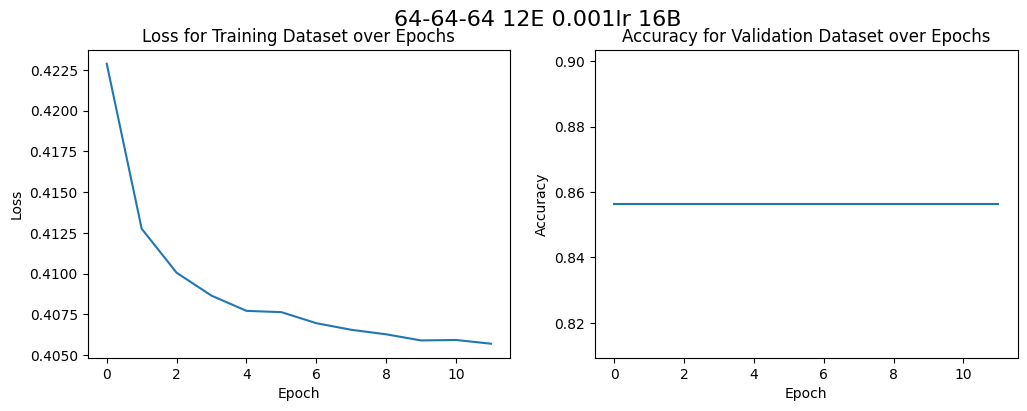

64-64-16 12E 0.001LR 16B
Epoch 1, Loss: 0.4232139665551715, Validation Accuracy: 85.64%
Epoch 2, Loss: 0.4117787619695149, Validation Accuracy: 85.64%
Epoch 3, Loss: 0.40937569045156946, Validation Accuracy: 85.64%
Epoch 4, Loss: 0.4082763916531908, Validation Accuracy: 85.64%
Epoch 5, Loss: 0.40757712911494365, Validation Accuracy: 85.64%
Epoch 6, Loss: 0.4071237238079745, Validation Accuracy: 85.64%
Epoch 7, Loss: 0.4068862488340089, Validation Accuracy: 85.64%
Epoch 8, Loss: 0.40646647174640044, Validation Accuracy: 85.64%
Epoch 9, Loss: 0.4060717634686441, Validation Accuracy: 85.64%
Epoch 10, Loss: 0.4059729740956638, Validation Accuracy: 85.64%
Epoch 11, Loss: 0.4055530317536329, Validation Accuracy: 85.64%
Epoch 12, Loss: 0.40537767995564333, Validation Accuracy: 85.64%


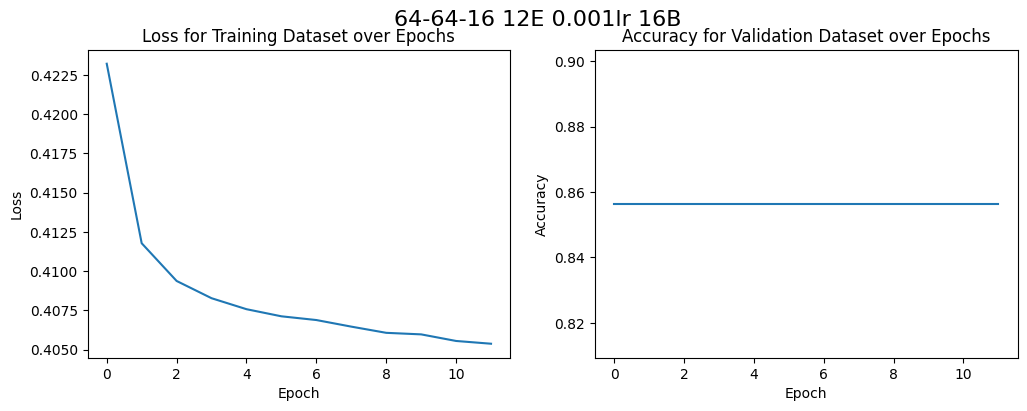

64-16-64 12E 0.001LR 16B
Epoch 1, Loss: 0.42177668647666955, Validation Accuracy: 85.64%
Epoch 2, Loss: 0.4121671133662763, Validation Accuracy: 85.64%
Epoch 3, Loss: 0.40939115575247426, Validation Accuracy: 85.64%
Epoch 4, Loss: 0.4085891920480693, Validation Accuracy: 85.64%
Epoch 5, Loss: 0.4076447386321845, Validation Accuracy: 85.64%
Epoch 6, Loss: 0.40706808016834684, Validation Accuracy: 85.64%
Epoch 7, Loss: 0.4068211938511628, Validation Accuracy: 85.64%
Epoch 8, Loss: 0.406309340094681, Validation Accuracy: 85.64%
Epoch 9, Loss: 0.40592902657359675, Validation Accuracy: 85.64%
Epoch 10, Loss: 0.40591074104405517, Validation Accuracy: 85.64%
Epoch 11, Loss: 0.40556083694509004, Validation Accuracy: 85.64%
Epoch 12, Loss: 0.4053128122009841, Validation Accuracy: 85.64%


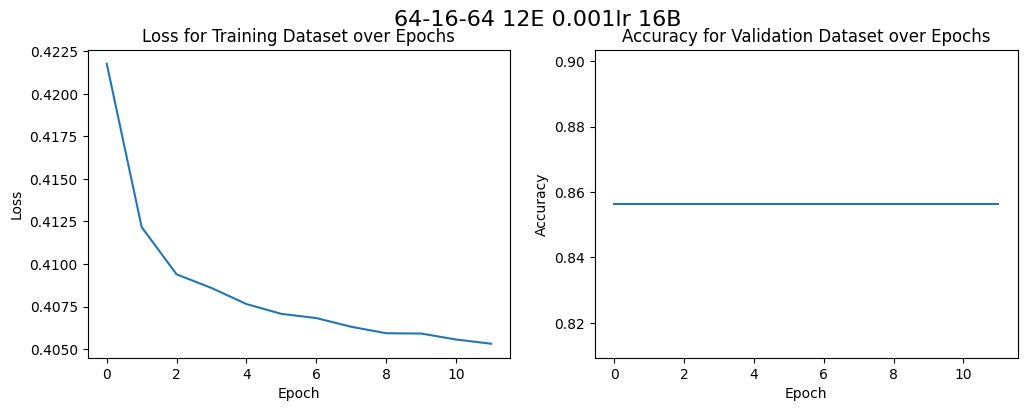

64-16-16 12E 0.001LR 16B
Epoch 1, Loss: 0.4206877193725251, Validation Accuracy: 85.64%
Epoch 2, Loss: 0.41175988897122784, Validation Accuracy: 85.64%
Epoch 3, Loss: 0.40905766331776294, Validation Accuracy: 85.64%
Epoch 4, Loss: 0.4080289510100862, Validation Accuracy: 85.64%
Epoch 5, Loss: 0.4071886108496943, Validation Accuracy: 85.64%
Epoch 6, Loss: 0.4067111157589137, Validation Accuracy: 85.64%
Epoch 7, Loss: 0.40630813634578117, Validation Accuracy: 85.64%
Epoch 8, Loss: 0.4060568280919869, Validation Accuracy: 85.64%
Epoch 9, Loss: 0.40586248496496263, Validation Accuracy: 85.64%
Epoch 10, Loss: 0.40562094200463794, Validation Accuracy: 85.64%
Epoch 11, Loss: 0.4052858432989833, Validation Accuracy: 85.64%
Epoch 12, Loss: 0.4051565696235058, Validation Accuracy: 85.64%


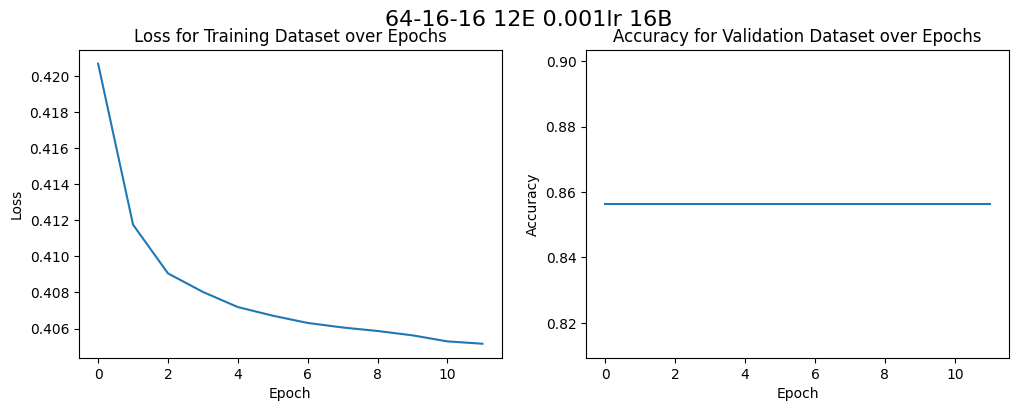

16-64-64 12E 0.001LR 16B
Epoch 1, Loss: 0.42461453290005813, Validation Accuracy: 85.64%
Epoch 2, Loss: 0.4121514784931537, Validation Accuracy: 85.64%
Epoch 3, Loss: 0.4095847446342055, Validation Accuracy: 85.64%
Epoch 4, Loss: 0.40846941884695614, Validation Accuracy: 85.64%
Epoch 5, Loss: 0.4076613950691232, Validation Accuracy: 85.64%
Epoch 6, Loss: 0.4071405574788341, Validation Accuracy: 85.64%
Epoch 7, Loss: 0.40693352218560697, Validation Accuracy: 85.64%
Epoch 8, Loss: 0.4067074680152661, Validation Accuracy: 85.64%
Epoch 9, Loss: 0.40637201917659105, Validation Accuracy: 85.64%
Epoch 10, Loss: 0.4063104710471859, Validation Accuracy: 85.64%
Epoch 11, Loss: 0.4059379152013789, Validation Accuracy: 85.64%
Epoch 12, Loss: 0.40583515725348834, Validation Accuracy: 85.64%


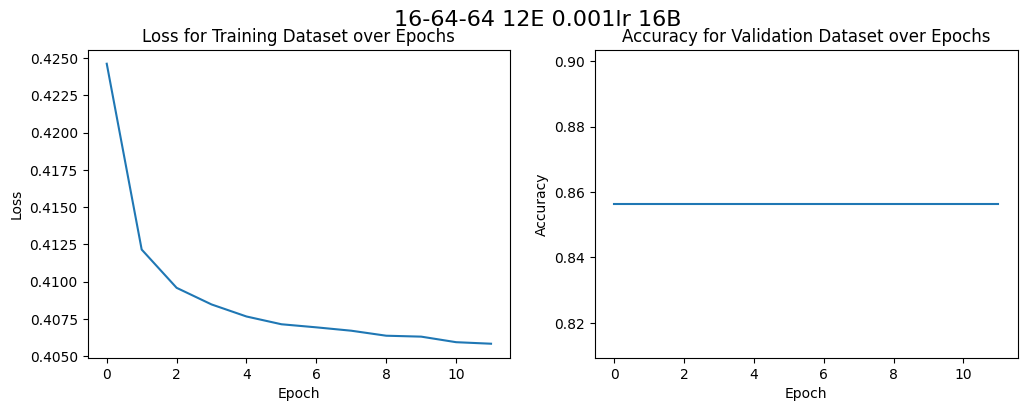

16-64-16 12E 0.001LR 16B
Epoch 1, Loss: 0.42676049682705014, Validation Accuracy: 85.64%
Epoch 2, Loss: 0.41199292505068036, Validation Accuracy: 85.64%
Epoch 3, Loss: 0.4095500380250283, Validation Accuracy: 85.64%
Epoch 4, Loss: 0.4083828771490284, Validation Accuracy: 85.64%
Epoch 5, Loss: 0.4077204568430754, Validation Accuracy: 85.64%
Epoch 6, Loss: 0.4072961909747538, Validation Accuracy: 85.64%
Epoch 7, Loss: 0.40684227562991315, Validation Accuracy: 85.64%
Epoch 8, Loss: 0.406417087571767, Validation Accuracy: 85.64%
Epoch 9, Loss: 0.40657493574255343, Validation Accuracy: 85.64%
Epoch 10, Loss: 0.40597492973686244, Validation Accuracy: 85.64%
Epoch 11, Loss: 0.40562788318073073, Validation Accuracy: 85.64%
Epoch 12, Loss: 0.40551917133699605, Validation Accuracy: 85.64%


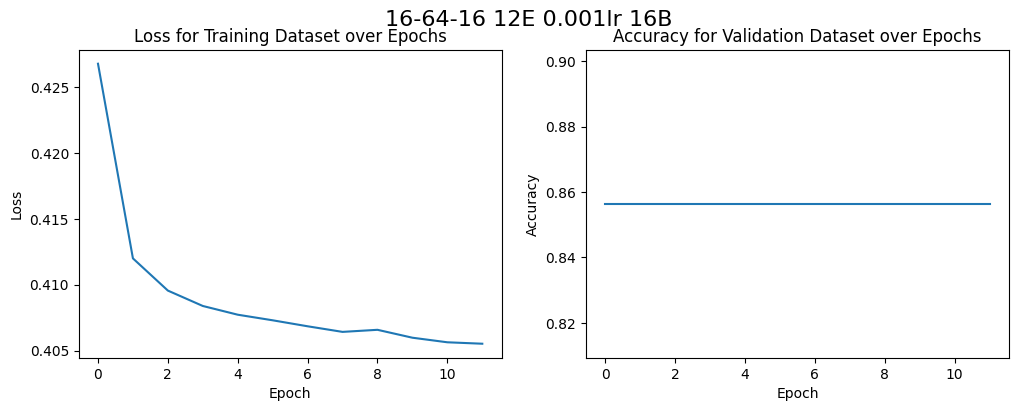

16-16-64 12E 0.001LR 16B
Epoch 1, Loss: 0.4231199541144495, Validation Accuracy: 85.64%
Epoch 2, Loss: 0.4114817392278524, Validation Accuracy: 85.64%
Epoch 3, Loss: 0.4093208382624649, Validation Accuracy: 85.64%
Epoch 4, Loss: 0.4082111851933669, Validation Accuracy: 85.64%
Epoch 5, Loss: 0.4076590519670867, Validation Accuracy: 85.64%
Epoch 6, Loss: 0.4068527095448873, Validation Accuracy: 85.64%
Epoch 7, Loss: 0.4065698714828088, Validation Accuracy: 85.64%
Epoch 8, Loss: 0.4063467029482126, Validation Accuracy: 85.64%
Epoch 9, Loss: 0.40603608918977285, Validation Accuracy: 85.64%
Epoch 10, Loss: 0.40585518623932076, Validation Accuracy: 85.64%
Epoch 11, Loss: 0.40563090432986915, Validation Accuracy: 85.64%
Epoch 12, Loss: 0.40543440209405407, Validation Accuracy: 85.64%


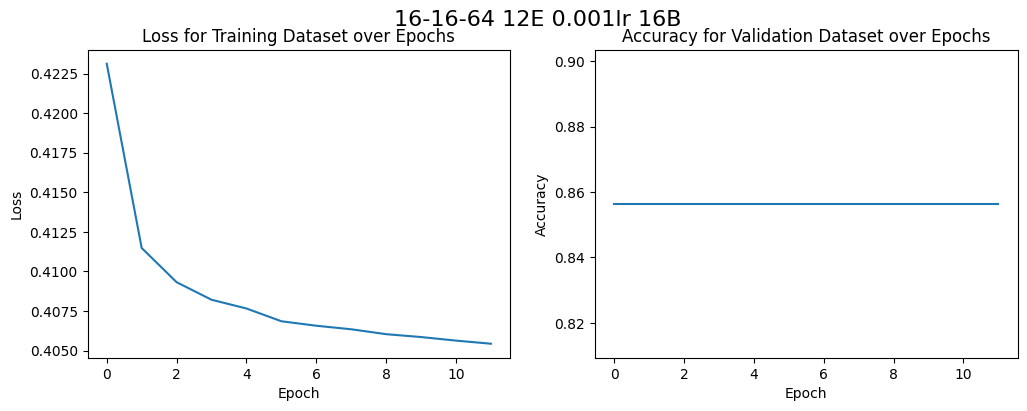

16-16-16 12E 0.001LR 16B
Epoch 1, Loss: 0.42364859167942726, Validation Accuracy: 85.64%
Epoch 2, Loss: 0.4109560568328314, Validation Accuracy: 85.64%
Epoch 3, Loss: 0.40920427247500507, Validation Accuracy: 85.64%
Epoch 4, Loss: 0.4082036269845703, Validation Accuracy: 85.64%
Epoch 5, Loss: 0.4077857508642473, Validation Accuracy: 85.64%
Epoch 6, Loss: 0.40732654837220633, Validation Accuracy: 85.64%
Epoch 7, Loss: 0.4070322282162837, Validation Accuracy: 85.64%
Epoch 8, Loss: 0.40651228612585083, Validation Accuracy: 85.64%
Epoch 9, Loss: 0.40625587872261865, Validation Accuracy: 85.64%
Epoch 10, Loss: 0.40605359341288616, Validation Accuracy: 85.64%
Epoch 11, Loss: 0.4058869197569665, Validation Accuracy: 85.64%
Epoch 12, Loss: 0.4057084818624328, Validation Accuracy: 85.64%


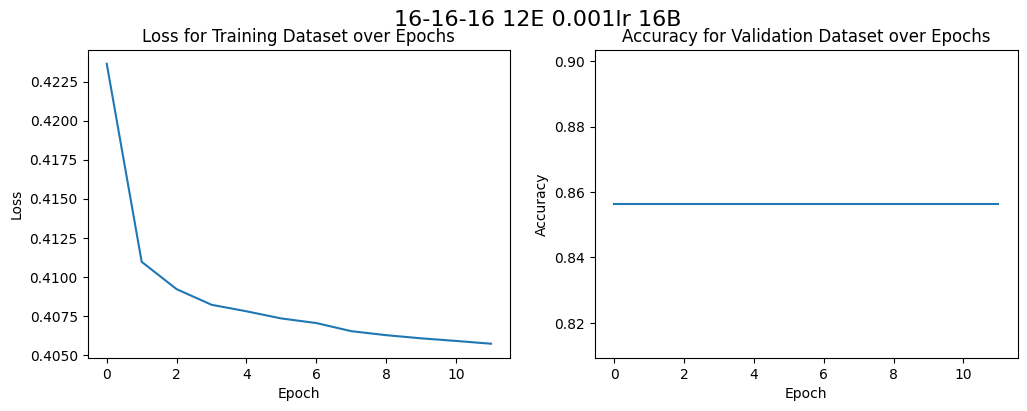

In [28]:
for Epochs in notorious_epochs:
    for LR in TT_learning_rates:
        for Batch in TT_batch_sizes:
            for HL1 in TT_hidden_layers:
                for HL2 in TT_hidden_layers:
                    for HL3 in TT_hidden_layers:
                        print(f'{HL1}-{HL2}-{HL3} {Epochs}E {LR}LR {Batch}B')
                        # Initialize the model
                        model = SimpleFeedForwardNN(INPUT_SIZE, HL1, HL2, HL3, OUTPUT_SIZE)

                        # Define the loss function
                        criterion = nn.BCELoss()

                        # Define the optimizer
                        optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=LR)

                        # Transform features and targets in the train dataset to tensors
                        train_features = torch.stack([torch.tensor(features, dtype=torch.float32) for features, _ in train_dataset])
                        train_targets = torch.stack([torch.tensor(target, dtype=torch.float32) for _, target in train_dataset])

                        #Create data loaders for training and validation
                        train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=Batch)
                        validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=Batch)

                        # Train and Save
                        loss_list, accuracy_list = train_SimpleFeedForwardNN(model, train_loader, validation_loader, criterion, optimizer, Epochs)

                        # Show Results
                        show_plot_loss_and_accuracy(loss_list, accuracy_list, f'{HL1}-{HL2}-{HL3} {Epochs}E {LR}lr {Batch}B')

                        append_learning(HL1, HL2, HL3, Epochs, LR, Batch, accuracy_list, loss_list)

                        # Save the model state dictionary to the specified filename
                        model_filename = generate_model_filename(algo_type, HL1, HL2, HL3, Epochs, LR, Batch)
                        torch.save(model.state_dict(), model_filename)
